# Оглавление
   [Исследование объявлений о продаже квартир. Введение](#шаг-0)
1. [Шаг 1. Загрузка файла с данными и изучение общей информации](#шаг-1)
2. [Шаг 2. Предобработка данных](#шаг-2)
    1. [Обработка пропусков и приведение данных к нужным типам](#шаг-2-1)
3. [Шаг 3. Расчёты и добавление в таблицу требуемых данных](#шаг-3)
    1. [Добавление цены квадратного метра ](#шаг-3-1)
    2. [Добавление дня недели, месяца и года публикации объявления](#шаг-3-2)
    3. [Добавление этажа квартиры ](#шаг-3-3)
    4. [Добавление вариантов этажей ](#шаг-3-4)
    5. [Добавление соотношения жилой и общей площади, а также отношения площади кухни к общей](#шаг-3-5)
4. [Шаг 4. Проведение исследовательского анализа данных и выполнение инструкций](#шаг-4)
    1. [Изучение параметров: площадь, цена, число комнат, высота потолков.](#шаг-4-1)
    2. [Изучение время продажи квартиры. Построение гистограммы. Расчёт среднего и медианы](#шаг-4-2)
    3. [Факторы, влияющие на стоимость квартиры](#шаг-4-4)
    4. [Выбор 10 населённых пунктов с наибольшим числом объявлений](#шаг-4-5)
5. [Общие выводы](#шаг-5)


## Исследование объявлений о продаже квартир. Введение <a name="шаг-0"></a>

**Целью** данного исследования является определение рыночной стоимости объектов недвижимости и  установление параметров, которые позволят построить автоматизированную систему для отслеживания аномалий и мошеннической деятельности.

Объект исследования: база данных  сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. База данных представлена для анализа в формате csv и содержит следующие атрибуты:

- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от
- публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах(м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

По каждой квартире на продажу доступны два вида данных: первые вписаны пользователем, вторые — получены автоматически на основе
картографических данных. 

*Пояснение:* апартаменты — это нежилые помещения, не относящиеся к жилому фонду, но имеющие необходимые условия для проживания.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pymystem3 import Mystem
from collections import Counter

df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [2]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
df.rename(columns={'cityCenters_nearest':'citycenters_nearest'}, inplace=True) #меняем заглавную букву на строчную

In [4]:
df.columns #проверяем имена столбцов

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'citycenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [5]:
df.sample(10) #смотрим как занесены данные 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
6195,13,4600000.0,73.8,2017-11-11T00:00:00,3,NaN,5.0,42.9,2,NaN,...,10.00,0.0,посёлок Шушары,18446.0,31021.0,0.0,NaN,0.0,NaN,11.0
16934,5,4100000.0,40.0,2017-10-17T00:00:00,1,1.75,37.0,17.4,5,NaN,...,8.34,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
11736,7,4000000.0,38.0,2016-02-16T00:00:00,1,NaN,10.0,18.0,8,NaN,...,8.00,NaN,Санкт-Петербург,42702.0,15205.0,2.0,162.0,0.0,NaN,672.0
2516,13,3950000.0,44.5,2017-06-22T00:00:00,2,2.60,9.0,27.5,9,NaN,...,7.00,1.0,Санкт-Петербург,16007.0,10400.0,1.0,367.0,1.0,114.0,53.0
1639,7,2600000.0,40.0,2017-11-29T00:00:00,1,NaN,9.0,20.0,3,NaN,...,10.00,NaN,посёлок Шушары,18399.0,29646.0,0.0,NaN,0.0,NaN,45.0
20550,20,4478000.0,60.0,2018-11-25T00:00:00,2,NaN,13.0,36.0,5,NaN,...,12.50,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,10.0
5895,12,2250000.0,73.0,2017-09-03T00:00:00,3,2.50,5.0,46.0,4,NaN,...,8.00,2.0,поселок Суходолье,NaN,NaN,NaN,NaN,NaN,NaN,180.0
1707,14,4600000.0,52.7,2017-12-27T00:00:00,2,3.00,5.0,37.1,2,NaN,...,6.70,NaN,Санкт-Петербург,19547.0,3816.0,0.0,NaN,3.0,319.0,187.0
7246,20,4450000.0,38.0,2017-11-24T00:00:00,1,NaN,24.0,17.6,16,NaN,...,11.00,2.0,Санкт-Петербург,33367.0,14445.0,0.0,NaN,0.0,NaN,84.0
22382,6,4400000.0,80.0,2017-10-07T00:00:00,2,3.00,4.0,48.0,4,NaN,...,13.00,1.0,Кронштадт,69449.0,51175.0,2.0,433.0,3.0,448.0,44.0


In [6]:
df.describe() #вызываем описание таблицы

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


 Строим диаграммы "Ящик с усами" для тех данных, по которым видим большие величины стандартных отклонений и где могут скрываться ошибки: total_images, total_area, rooms, ceiling_height, floors_total, living_area, floor, kitchen_area

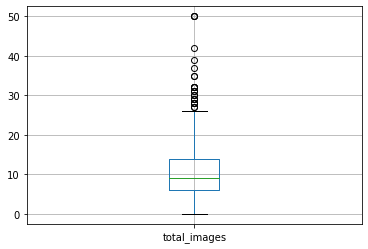

In [7]:
df.boxplot(column='total_images')
plt.show()

Здесь явно видны выбросы. Кроме того, по правилам Яндекс к объявлению можно прикрепить не более 30 фотографий.

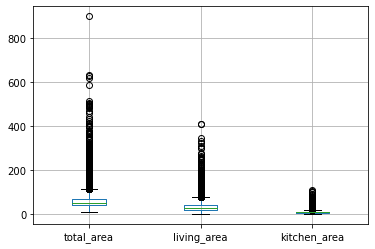

In [8]:
df.boxplot(column=['total_area', 'living_area', 'kitchen_area'])
plt.show()

В процессе предобработки данных изучим всплеск по total_area

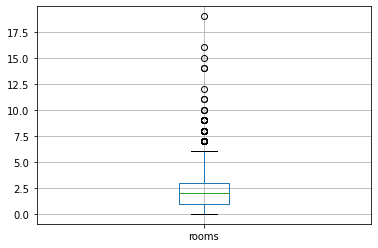

In [9]:
df.boxplot(column='rooms')
plt.show()

Очень большие всплески по количеству комнат выше 12 единиц.

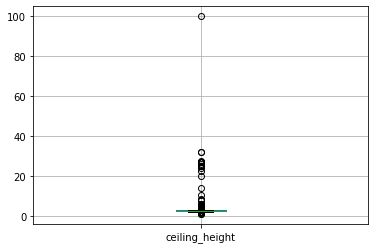

In [10]:
df.boxplot(column='ceiling_height')
plt.show()

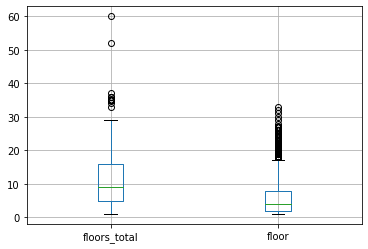

In [11]:
df.boxplot(column=['floors_total', 'floor']) #смотрим выбросы по этажности
plt.show()

Согласно диаграмме floors_total содержат значения более 50. 

### Вывод

- Данные содержат 22 колонки и 23699 строк.
- Требуется замена типа данных в first_day_exposition  с object в datatype.
- Также следует заменить тип данные с float на integer в столбце floors_total.          
- В полученных данных большое количество пропущенных значений, часть из которых предстоит заполнить.
- В данных total_images есть явные выбросы, которые следует проанализировать.
- Из описания следует, что ряд столбцов содержит артефактные значения: очень высокие значения максимума ceiling_height и   floors_total (если это не Лахта-центр). Также обнаружено нереалистичное значение минимума в ceiling_height. 

## Шаг 2. Предобработка данных <a name="шаг-2"></a>

### Обработка пропусков и приведение данных к нужным типам   <a name="шаг-2-1"></a>

In [12]:
df.isna().mean() #проверяем, где содержатся пропуски и с какой долей

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.387991
floors_total            0.003629
living_area             0.080299
floor                   0.000000
is_apartment            0.882906
studio                  0.000000
open_plan               0.000000
kitchen_area            0.096122
balcony                 0.486054
locality_name           0.002068
airports_nearest        0.233850
citycenters_nearest     0.232879
parks_around3000        0.232837
parks_nearest           0.659100
ponds_around3000        0.232837
ponds_nearest           0.615596
days_exposition         0.134225
dtype: float64

Данные содержат достаточно большое число пропусков. В столбце is_apartment пропущено порядка 88% данных. Данных о близлежащих  парках и прудах нет в 66% и 62% случаев соответственно.

*last_price*

In [13]:
df['last_price'] = df['last_price']/1000000 #приводим стоимость к миллионам

*total_images*

В столбце нет пропущенных значений, но необходимо устранить выбросы, которые были обнаружены при построении боксплота.

In [14]:
df.query('total_images >30').sort_values(by='total_images') #размещение более 30 фотографий запрещено правилами

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5349,31,11.990,92.5,2017-12-07T00:00:00,3,NaN,25.0,51.4,22,NaN,...,15.0,1.0,Санкт-Петербург,30546.0,11209.0,1.0,433.0,1.0,700.0,47.0
22517,31,9.000,82.6,2018-02-22T00:00:00,3,3.0,5.0,52.7,5,NaN,...,9.0,NaN,Санкт-Петербург,28576.0,7121.0,2.0,91.0,1.0,691.0,95.0
99,32,9.600,90.0,2017-09-26T00:00:00,4,NaN,5.0,67.0,2,NaN,...,8.0,NaN,Санкт-Петербург,23277.0,2818.0,0.0,NaN,0.0,NaN,104.0
7393,32,8.290,113.2,2017-04-28T00:00:00,4,NaN,6.0,70.4,4,NaN,...,10.4,NaN,Санкт-Петербург,24177.0,2342.0,2.0,356.0,3.0,457.0,225.0
7938,32,17.000,150.0,2017-09-26T00:00:00,3,3.5,6.0,99.3,4,NaN,...,16.0,NaN,Санкт-Петербург,24980.0,3555.0,0.0,NaN,0.0,NaN,165.0
21076,32,8.300,84.7,2017-11-11T00:00:00,3,NaN,14.0,49.9,3,NaN,...,11.3,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
308,35,5.700,83.9,2018-02-01T00:00:00,3,2.6,5.0,51.8,2,NaN,...,9.6,NaN,Красное Село,27245.0,30670.0,0.0,NaN,0.0,NaN,47.0
10523,35,17.000,90.0,2017-11-10T00:00:00,3,NaN,16.0,52.0,6,NaN,...,14.0,4.0,Санкт-Петербург,30215.0,6255.0,0.0,NaN,1.0,113.0,35.0
21199,37,11.500,65.7,2018-02-01T00:00:00,2,NaN,25.0,23.0,10,NaN,...,21.0,2.0,Санкт-Петербург,10663.0,12738.0,0.0,NaN,0.0,NaN,64.0
1058,39,1.900,63.0,2017-09-29T00:00:00,3,NaN,5.0,44.2,5,NaN,...,6.3,1.0,деревня Лопухинка,NaN,NaN,NaN,NaN,NaN,NaN,106.0


In [15]:
df['total_images'] = df['total_images'].replace([31, 32, 35, 37, 39, 42, 50], 30) #заменим все показатели >30 на 30

*total_area*

In [16]:
df.query('total_area >500').sort_values(by='total_area') #смотрим на выбросы

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8018,20,84.0,507.0,2015-12-17T00:00:00,5,4.45,7.0,301.5,7,True,...,45.5,1.0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,1078.0
4237,1,50.0,517.0,2017-10-14T00:00:00,7,NaN,4.0,332.0,3,NaN,...,22.0,NaN,Санкт-Петербург,22835.0,1847.0,2.0,477.0,2.0,540.0,NaN
5358,20,65.0,590.0,2019-02-14T00:00:00,15,3.50,6.0,409.0,3,NaN,...,100.0,NaN,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
15651,20,300.0,618.0,2017-12-18T00:00:00,7,3.40,7.0,258.0,5,NaN,...,70.0,NaN,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0
3117,19,140.0,631.0,2019-03-30T00:00:00,7,NaN,5.0,NaN,5,NaN,...,60.0,NaN,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
12859,20,140.0,631.2,2019-04-09T00:00:00,7,3.90,4.0,322.3,4,NaN,...,19.5,1.0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
19540,8,420.0,900.0,2017-12-06T00:00:00,12,2.80,25.0,409.7,25,NaN,...,112.0,NaN,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


Данные похожи на истинные, поэтому не будем избавляться от этих строк.

*rooms*

In [17]:
df.query('rooms >10').sort_values(by='rooms') #по количеству комнат смотрим на выбросы более 10 единиц

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
648,3,17.500,183.7,2018-07-01T00:00:00,11,3.40,7.0,138.8,7,NaN,...,13.3,NaN,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,NaN
9688,8,33.000,194.1,2017-02-07T00:00:00,11,3.43,5.0,129.0,2,NaN,...,11.9,NaN,Санкт-Петербург,21469.0,1015.0,1.0,686.0,2.0,66.0,813.0
19540,8,420.000,900.0,2017-12-06T00:00:00,12,2.80,25.0,409.7,25,NaN,...,112.0,NaN,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0
866,5,25.000,363.0,2017-12-23T00:00:00,14,3.16,5.0,222.0,4,NaN,...,16.6,NaN,Санкт-Петербург,38076.0,7950.0,0.0,NaN,2.0,435.0,418.0
20829,6,28.659,245.4,2016-03-31T00:00:00,14,NaN,4.0,168.3,2,NaN,...,25.9,0.0,Санкт-Петербург,21104.0,2054.0,3.0,541.0,2.0,118.0,95.0
5358,20,65.000,590.0,2019-02-14T00:00:00,15,3.50,6.0,409.0,3,NaN,...,100.0,NaN,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
18848,6,28.500,270.0,2015-03-02T00:00:00,16,3.00,4.0,180.0,4,NaN,...,13.0,1.0,Санкт-Петербург,23575.0,4142.0,1.0,516.0,0.0,NaN,1365.0
14498,6,32.250,374.6,2018-06-09T00:00:00,19,NaN,5.0,264.5,2,NaN,...,27.6,NaN,Санкт-Петербург,19497.0,3574.0,0.0,NaN,2.0,548.0,114.0


Анализ результатов позволяет говорить о большинстве предложений в списке, что это возможно бывшие комммунальные квартиры: близость к центру и относительно невысокая стоимость за квадратный метр. Данные также не будем рассматривать в качестве выбросов. 

*ceiling_height*

Большая доля пропусков в столбце ceiling_height - 39%. Попробуем заменить значения на аналогичные для коррелирующих групп. Посмотрим, с чем коррелирует высота потолков:

In [18]:
df.corr().head(5) #пяти строк достаточно для визуального анализа корреируемости ceiling_height

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
total_images,1.000000,0.104365,0.115016,0.098917,-0.002238,0.009946,0.104302,0.030889,-0.029352,-0.024459,0.103863,0.120701,-0.002223,-0.047522,0.021602,-0.008399,-0.011382,-0.003055,-0.026301
last_price,0.104365,1.000000,0.653675,0.363343,0.085430,-0.006984,0.566492,0.026576,-0.025362,-0.008802,0.519869,0.029646,-0.026239,-0.206747,0.151058,-0.016414,0.159996,-0.084809,0.081146
total_area,0.115016,0.653675,1.000000,0.758344,0.095490,-0.075774,0.939537,-0.024754,-0.072653,-0.034885,0.609121,0.047937,-0.030753,-0.231446,0.164689,-0.021497,0.162346,-0.097969,0.149675
rooms,0.098917,0.363343,0.758344,1.000000,0.054457,-0.228215,0.845977,-0.150862,-0.147286,-0.087500,0.269945,0.017991,-0.061199,-0.184864,0.137257,-0.054549,0.092693,-0.057689,0.126961
ceiling_height,-0.002238,0.085430,0.095490,0.054457,1.000000,-0.028732,0.090650,-0.011798,0.001674,0.042777,0.087641,0.040523,-0.023947,-0.091689,0.065915,-0.019167,0.078209,-0.059090,0.019091


Чёткой корреляции нет, поэтому заполнять пустые значения необходимо средним или медианным значением

Но сначала устраним существенные пики в высоте потолков, такие как 100 или 30 метров:

In [19]:
df.query('ceiling_height > 10 or ceiling_height < 2') #определим, какая недвижимость представлена выстой потолков более 10 метров.

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3.600,55.2,2018-07-12T00:00:00,2,25.00,5.0,32.0,2,False,...,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
3148,14,2.900,75.0,2018-11-12T00:00:00,3,32.00,3.0,53.0,2,NaN,...,8.00,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4643,0,4.300,45.0,2018-02-01T00:00:00,2,25.00,9.0,30.0,2,NaN,...,7.00,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4876,7,3.000,25.0,2017-09-27T00:00:00,0,27.00,25.0,17.0,17,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5076,0,3.850,30.5,2018-10-03T00:00:00,1,24.00,5.0,19.5,1,True,...,5.50,NaN,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0
5246,0,2.500,54.0,2017-10-13T00:00:00,2,27.00,5.0,30.0,3,NaN,...,9.00,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0
5669,4,4.400,50.0,2017-08-08T00:00:00,2,26.00,9.0,21.3,3,NaN,...,7.00,2.0,Санкт-Петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0
5712,5,1.500,42.8,2017-08-14T00:00:00,2,1.20,2.0,27.5,1,NaN,...,5.20,NaN,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
5807,17,8.150,80.0,2019-01-09T00:00:00,2,27.00,36.0,41.0,13,NaN,...,12.00,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
6246,6,3.300,44.4,2019-03-25T00:00:00,2,25.00,5.0,31.3,5,NaN,...,5.70,NaN,Кронштадт,68923.0,50649.0,1.0,417.0,2.0,73.0,NaN


Отмечаем явную опечатку в виде перемещения запятой или добавление лишнего нуля. 

In [20]:
df['ceiling_height'] = df['ceiling_height'].replace([1, 1.2, 1.75, 10.3, 14, 20, 22.6, 24, 25, 26, 27, 27.5, 28, 32, 100], 
                                                        [2.7, 2.7, 2.7, 2.7, 2.7, 2.7, 2.26, 2.4, 2.5, 2.6, 2.7, 2.75, 2.8, 3.2, 2.7]) 
#заменим всплески вручную. 

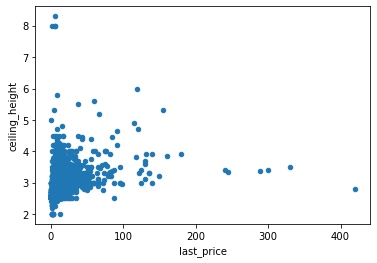

In [21]:
df.plot(x='last_price', y= 'ceiling_height', kind='scatter'); 
#экстремальных значений таких как 1, 20 или 100 не осталось

In [22]:
df.corr().head(5) #смотрим, как теперь коррелируют данные

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
total_images,1.000000,0.104365,0.115016,0.098917,0.044123,0.009946,0.104302,0.030889,-0.029352,-0.024459,0.103863,0.120701,-0.002223,-0.047522,0.021602,-0.008399,-0.011382,-0.003055,-0.026301
last_price,0.104365,1.000000,0.653675,0.363343,0.379127,-0.006984,0.566492,0.026576,-0.025362,-0.008802,0.519869,0.029646,-0.026239,-0.206747,0.151058,-0.016414,0.159996,-0.084809,0.081146
total_area,0.115016,0.653675,1.000000,0.758344,0.457969,-0.075774,0.939537,-0.024754,-0.072653,-0.034885,0.609121,0.047937,-0.030753,-0.231446,0.164689,-0.021497,0.162346,-0.097969,0.149675
rooms,0.098917,0.363343,0.758344,1.000000,0.280616,-0.228215,0.845977,-0.150862,-0.147286,-0.087500,0.269945,0.017991,-0.061199,-0.184864,0.137257,-0.054549,0.092693,-0.057689,0.126961
ceiling_height,0.044123,0.379127,0.457969,0.280616,1.000000,-0.089714,0.435809,-0.045710,0.018055,0.010991,0.400938,-0.078390,-0.102373,-0.349825,0.259572,-0.055488,0.225714,-0.136641,0.125381


Теперь total_area, living_area  и kitchen_area показывают наибольшую взаимосвязь с  ceiling_height. Произведём замену пустых значений  ceiling_height на основе этой взаимосвязи:

In [23]:
#df['ceiling_height'] = df['ceiling_height'].fillna(df.groupby(['total_area', 'living_area', 'kitchen_area'])['ceiling_height'].transform('median'))

In [24]:
df['ceiling_height'] = df['ceiling_height'].fillna(df.groupby('total_area')['ceiling_height'].transform('median'))

In [25]:
df['ceiling_height'] = df['ceiling_height'].fillna(df.groupby('living_area')['ceiling_height'].transform('median'))

In [26]:
df['ceiling_height'] = df['ceiling_height'].fillna(df.groupby('kitchen_area')['ceiling_height'].transform('median'))

*floors_total*

Общее количество этажей  floors_total тоже имеет пропущенные значения, которые заменим на значения из указанного этажа выставленной недвижимости floor. Для этого переведём floors_total в формат integer, предварительно заменив все пропуски нулями

In [27]:
df['floors_total'] =  df['floors_total'].fillna(0) 
df['floors_total'] = df['floors_total'].astype(np.int64)    

In [ ]:
df['floors_total'] =  df['floors_total'].replace(0, df['floor'])

In [ ]:
df['floors_total'].value_counts(dropna=False) #проверяем замену

Смотрим на два значения 60 и 52 этажа:

In [ ]:
df.query('floors_total >=50').sort_values(by='total_images')

Поменяем floors_total для 52 и 60 этажей на floor 18  и 4 из этих же объявлений:

In [ ]:
df['floors_total'] = df['floors_total'].replace([52, 60], [18, 4]) 

*living_area*

Замену NaN в столбце living_area произведём на ноль, т.к. отсутствующие значения показывают, что помещение не является жилым. 

In [ ]:
df['living_area'] =  df['living_area'].fillna(0)

*is_apartment*

Столбец is_apartment содержит очень большое количество пропущенных значений, но осуществлять замену будет некорректным. Столбец служит как дополнительный ориентир при оценки других параметров. По этой же причине не будем менять тип object на булевый.

*kitchen_area*

В столбце kitchen_area пропущено 2278 значений. Предположим, что это студии:

In [ ]:
df.query('kitchen_area == "NaN" or studio ==True') 

В kitchen_area пропущены значения именно по студиям, поэтому можем присвоить им ноль: 

In [ ]:
df['kitchen_area'] =  df['kitchen_area'].fillna(0)

*balcony*

Данные по балконам также имеют ряд пропусков. 

In [ ]:
df['balcony'].value_counts(dropna=False)


In [ ]:
#заменим пропуски на 99 для перевода целочисленный формат, т.к. нули уже есть
df['balcony'] =  df['balcony'].fillna(99) 
df['balcony'] = df['balcony'].astype(np.int64) #меняем тип данных    

In [ ]:
df[(df['balcony'] == 5) & (df['total_area'] <=80)].sample(10) 
#проверим, какие относительно нrepla

Вероятно, в столбце balcony в данных закралась ошибка: пять балконов в однокомнатной квартире с площадью 25 квадратных метров- это уникальное явление.
Возможно, стоит заменить некорректные значения на медианные по группам на основе метража или количества комнат. Посмотрим корреляцию: 

In [ ]:
df.corr().head(12) 

На основе коэффициентов корреляции, ни один из которых не превышает даже 0,2, откуда  делаем вывод, что заполнить количество пустых строк в balcony на основе зависимых значений невозможно. Поэтому оставляем наше значение 99.

*first_day_exposition*

Для более удобного анализа данных во времени необходимо перевести данные  first_day_exposition  из object в формат datetime: 

In [ ]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y/%m/%d')

df['first_day_exposition']

*Данные о парках и прудах*

In [ ]:
# Конвертируем метры в километры
df['airports_nearest'] = df['airports_nearest'] / 1000
df['citycenters_nearest'] = df['citycenters_nearest'] / 1000
df['parks_nearest'] = df['parks_nearest'] / 1000
df['ponds_nearest'] = df['ponds_nearest'] / 1000

Классифицируем расстояние от ценра города. Примем в качестве точки отсчёта Дворцовую площадь (Яндекс также выдаёт в качестве центра города Дворцовую площадь) и введём свою классификацию.

- Расстояние от **0 до 3 км** - Центр. В качестве критерия принято расстояние от Дворцовой до Обводного канала. Сюда войдут восточная часть Васильевского острова, большая часть Петроградки, Финляндский вокзал и Площадь Восстания.

- Расстояние от **3 до 6 км** - Серый пояс, площади, где расположены промышленные предприятия, основанные в 18-20 веках. Здесь чаще всего можно встретить лофты с высокими потолками и огромной общей площадью. Также в эту категорию входит территория Крестовского острова, где размещаются наиболее дорогие и элитные объекты жилой недвижимости.

- Расстояние от **6 до 12 км** - КАД. Основной радиус ограничивается Кольцевой автомобильной дорогой.

- Расстояние **более 12 км** - ЛО. Условно это расстояние можно считать Ленинградской областью.

In [ ]:
def distance_options(row):
    if row['citycenters_nearest'] > 12:
        return 'более 12 км'
    elif row['citycenters_nearest'] >6 <= 12:
        return '6 - 12 км'
    elif row['citycenters_nearest'] >3 <= 6:
        return '3 - 6 км'
    else:
        return '0 - 3 км'

df['distfnce_from_center'] = df.apply(distance_options, axis=1) #создаём для категорий столбец

*days_exposition*

In [ ]:
df['days_exposition'].value_counts(dropna=False)

Мы не знаем каковы причины отсутствия данных в некоторых стрках days_exposition. Предположим, что значение NaN было выставлено для той недвижимости, которая была продана мгновенно, но замену на ноль производить не будем - это серъёзно повлияет на медианные и  средние значения

### Вывод

- Пропуски в столбце ceiling_height заполнены на основе корреляции значений площадям помещений - общей, жилой и площади кухни.  Высота потолков содержала аномальные значения более 10 метров. Анализ показал, что при внесении данных были допущены ошибки и запятые сместились.
- Пропуски в столбце floors_total заполнены на основе  значений этажа, где размещена недвижимость.
- В столбце living_area пропущенные значения заменены на ноль, т.к. отсутствие значений показывают, что помещение не является жилым.
- Пропуски по столбцу kitchen_area были заменены на ноль, именно пропущенные значения соответствовали значениям studio =True. 
- Пропуски в столбце по количеству балконов заменены на 99 т.к. ноль уже обозначен. В столбце балконы встречаются аномальные значения: 5 балконов для помещений 25 кв.м. Устранить эту аномалию заменой на ноль или 1 нельзя. 
- Даты переведены из object в формат datetime.
- Данные is_apartment, где пропущено порядка 88% данных не подверглись никаким изменениям, т.к. корректно заменить невозможно и  параметр будет служить для уточнения значений других столбцов. 
- Расстояния в метрах были конвертированы в километры. Расстояниям от центра были присвоены категории. 

## Шаг 3. Расчёты и добавление  в таблицу требуемых данных <a name="шаг-3"></a>

### Добавление цены квадратного метра <a name="шаг-3-1"></a>

In [ ]:
df['price_for_meter'] = df['last_price']/df['total_area'] #сформирован новый столбец

### Добавление дня  недели, месяца и года публикации объявления <a name="шаг-3-2"></a>

Формируем новые столбцы с указанием дня недели публикации объявления (0 -понедельник, 6 - воскресенье), месяца и года публикации с помощью  DatetimeIndex и атрибутов dayofweek, month, year.

In [ ]:
df['day_of_week']= pd.DatetimeIndex(df['first_day_exposition']).dayofweek #получаем столбец с днями недели

In [ ]:
df['month']= pd.DatetimeIndex(df['first_day_exposition']).month #получаем столбец с месяцами

In [ ]:
df['year']= pd.DatetimeIndex(df['first_day_exposition']).year #получаем отдельный столбец с годами

### Добавление вариантов этажей  <a name="шаг-3-4"></a>

Необходимо классифицировать этаж по трём категориям: первый этаж, последний этаж, другой. Также имеем ввиду, что столбец содержит пустые строки. Для этого воспользуемся функцией:

In [ ]:
def floor_options(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

df['floor_options'] = df.apply(floor_options, axis=1) #создаём для категорий столбец


In [ ]:
df.sample(10) #проверяем, правильно ли распределились данные по категориям

### Добавление соотношения жилой и общей площади, а также отношения площади кухни к общей <a name="шаг-3-5"></a>

Добавляем столбец соотношения жилой и общей площади, где показатель будет отражать долю жилой площади в общей:

In [ ]:
df['living_area_to_total'] = df['living_area']/df['total_area']

Соотношение площади кухни и общей площади добавим в следующий столбец:

In [ ]:
df['kitchen_area_to_total'] = df['kitchen_area']/df['total_area']

In [ ]:
df.head() 

## Шаг 4. Проведение исследовательского анализа данных и выполнение инструкций <a name="шаг-4"></a>

### Изучение параметров: площадь, цена, число комнат, высота потолков.  <a name="шаг-4-1"></a>

Создадим новый датафрейм, куда войдут все требуемые значения: total_area, living_area, kitchen_area, last_price, rooms, ceiling_height.

In [ ]:
df1 = df[['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height']]

In [ ]:
df1.head()

In [ ]:
pd.plotting.scatter_matrix(df1, figsize=(15, 15)); #построим матрицу рассеяния

In [ ]:
df1.corr()

Из диаграммы разброса total_area/living_area видна прямая зависимость. Также между этими столбцами наблюдается наибольшая зависимость. Но есть определённый кластер данных откуда следует, что у ряда предложений с ростом общей площади жилая площадь не увеличивается и в ряде случаев равна нулю. Вероятно, речь идёт о коммерческой, нежилой недвижимости.  Именно это влияет на  невысокий коэффициент корреляции -  0,79. 
Интересна также другая зависимость last_price/room, где можно было бы предположить четкую линейную связь, но с увеличением количества комнат цена увеличивается непропорционально. Прямой зависимости также не наблюдается в соотношении living_area и rooms. На основании этого можем предположить, что среди объявлений о продаже недвижимости нередки предложения больших площадей с маленькими комнатами. Под это описание подходят старые коммунальные квартиры, где  высота потолков также не связана со стоимостью, а в некоторых случаях это может работать обратно пропорционально. 

### Изучение времени продажи квартиры. Построение гистограммы. Расчёт среднего и медианы
<a name="шаг-4-2"></a>

In [ ]:
plt.figure(figsize = (14, 5))
df['first_day_exposition'].hist(bins = 100)
plt.title('Гистограмма распределения дат размещения', fontsize = 14)
plt.ylabel('Частота')
plt.xlabel('Даты');

In [ ]:
plt.figure(figsize = (18, 5))
df['days_exposition'].hist(bins = 100)
plt.title('Гистограмма распределения дней размещения', fontsize = 14)
plt.ylabel('Частота')
plt.xlabel('Дни показов');

In [ ]:
mediane = df['days_exposition'].median() #расчитаем медианное значение количества дней размещения

In [ ]:
mediane

In [ ]:
plt.figure(figsize = (18, 5))
df['days_exposition'].hist(bins = 100, range=(0, mediane)) #ограничиваем гистограмму медианным значением
plt.title('Гистограмма распределения дней размещения - срез по медиане', fontsize = 14)
plt.ylabel('Частота')
plt.xlabel('Дни показов');

С высокой долей вероятности недвижимость продаётся в первые 95 дней размещения.

Посмотрим, зависит ли скорость продажи от дней недели в которые были размещены объявления

In [ ]:
df2=df[['days_exposition', 'day_of_week', 'month']]

In [ ]:
df2.groupby('day_of_week')['days_exposition'].count().plot(figsize=(15,3)).set_ylabel('всего количество дней размещения');

График показывает, что количество дней в течение которых объявление будет показано (до момента продажи) зависит от дня недели размещения. Объявления, которые были размещены в субботу и воскресенье продаются быстрее. Размещение в понедельник снижает шансы продать быстрее. 
Посмотрим, влияет ли месяц размещения на продажи:

In [ ]:
df2.groupby('month')['days_exposition'].count().plot(figsize=(15,3)).set_ylabel('всего количество дней размещения');

Размещение объявлений в январе, мае и декабре совпадает с наименьшим количеством дней в течение которых недвижимость продаётся. Показатели мая могут быть обусловлены большим количеством желающих приобрести недвижимость для будущих студентов петербургских ВУЗов.

### Факторы, влияющие на стоимость квартиры <a name="шаг-4-4"></a> 

Создадим список с перечнем всех факторов, которые могут влиять на стоимость недвижимости:

In [ ]:
list_of_factors = ['total_area', 'kitchen_area', 'living_area', 'rooms', 'ceiling_height', 'floor', 'citycenters_nearest', 'parks_around3000', 'ponds_around3000']

In [ ]:
df[list_of_factors].hist(bins=25, figsize=(12, 12));

Рассмотрим более детально влияние total_area на стомость 

In [ ]:
df['total_area'].corr(df['last_price']) #зависимость общей площади от итоговой стоимости

In [ ]:
df['area_class'] = pd.cut(df['total_area'],20) #разделяем площадь на равные отрезки
pivot_price = df.pivot_table(index=['area_class'], values='last_price', aggfunc='median') #берём медианные значения
pivot_price.columns = ['price_median']
pivot_price['price_median'].map('{:.1f}'.format)


Корреляция не близка к 1 поскольку существуют проседающие значения стоимости по некоторым помещениям с большой площадью (в интервале 411-456 кв.м). Предполагается, что именно коммунальные квартиры негативно влияют на общую стоимость. Проверим распределение на параметре удаленности от центра:

In [ ]:
pivot_price = df.pivot_table(index=['distfnce_from_center', 'area_class'], values='last_price', aggfunc='median') #берём медианные значения
pivot_price.columns = ['price_median']
pivot_price['price_median'].map('{:.1f}'.format)


Здесь мы видим, что в интервалах 456 -544 от 0 до 3 км от центра и   411-456 кв.м для 3 - 6 км радиуса происходит значительное снижение медианной стоимости. 
Гипотеза с коммуналками подтвердилась. 
Если не учитывать этот факт, зависимость стоимости недвижимости от общей площади будет более чёткой.

Рассмотрим влияние этажа на стоимость квартиры.

In [ ]:
df['floor'].corr(df['last_price'])

Как видим, на первый взгляд корреляции нет. Но изучим более подробно. Предположим, что, например, верхние этажи будут продаваться в зависимости от расположения дома на карте города.

In [ ]:
pivot_price = df.pivot_table(index=['distfnce_from_center', 'floor_options'], values='last_price', aggfunc='median') #берём медианные значения
pivot_price.columns = ['floor_price_median']
pivot_price['floor_price_median'].map('{:.1f} млн.'.format)

Этажность влияет на стоимость в зависимости от района расположения квартиры:
- в центре первые и последние этажи продаются несколько дешевле, чем средние. Жить на первых этажах шумно и пыльно, последние традиционно считаются территорией протекающих крыш старого фонда, хотя такая проблема в настоящее время во многом решена.
- самое дорогое жильё расположено в радиусе от 3 до 6 км от центра и здесь первые этажи наиболее дёшевы. Последние этажи здесь дороже всего. Это является следствием того, что данная территория застраивается новыми высотными домами и именно последние этажи привлекательны благодаря своему великолепному виду на Петербург и отсутствию проблем с протечками.  
- недвижимость предлагаемая в большем удалении от центра чаще всего представлена высотками, где наиболее комфортны для жизни средние этажи.

### Выбор 10 населённых пунктов с наибольшим числом объявлений <a name="шаг-4-5"></a> 

In [ ]:
df['locality_name'].unique() 

Список неоднороден, поэтому используем лемматизацию 

In [ ]:
df.dropna(subset=['locality_name'], inplace=True) #прежде исключим незаполненные строки

In [ ]:
m = Mystem()
def lemmas(locality_name):
    lemmas_list = ' '.join(m.lemmatize(locality_name))
    return lemmas_list

df['lemma_locality_name'] = df['locality_name'].apply(lemmas).values.tolist()

In [ ]:
lemma_locality_name = df['locality_name'].values.tolist()
common_list = Counter(lemma_locality_name).most_common(10)

In [ ]:
lemma_locality_name

In [ ]:
common_list #смотрим, что является наиболее популярным

In [ ]:
df3  = pd.DataFrame(lemma_locality_name) #создаём новый датафрейм для анализа

In [ ]:
df['lemma_locality_name']=df3[0] #присоединяем полученные данные к базовому датафрейму

Определяем медианные значения цен за объект для выбранного списка городов:

In [ ]:
pivot_city = df.pivot_table(index='lemma_locality_name', values='last_price', aggfunc='median').query('("Санкт-Петербург", "посёлок Мурино", "посёлок Шушары", "Всеволожск", "Пушкин", "Колпино", "посёлок Парголово", "Гатчина", "деревня Кудрово", "Выборг") in lemma_locality_name')
pivot_city.columns = ['localname']
pivot_city['localname'].map('{:.3f} млн.'.format)

In [ ]:
pivot_city['localname'].plot(y='lemma_locality_name', figsize=(12,5), kind='bar')
plt.title('Медианная цена за объект недвижимости, млн.', fontsize = 15)
plt.ylabel('')
plt.xlabel('');

Медианные цены практически равны - они варьируются в пределах 4.5 млн.  Максимальная медианная цена установлена в Кудрово, минимальная - в Гатчине. В течение последних 10 лет жители Санкт-Петербуга стремятся покупать недвижимость в пригородных районах, что, соответственно повлияло на рост цен на недвижимость в Ленобласти. 

### Вывод
- Предложения недвижимости разнообразны. Нет чёткой прямой зависимости стоимости от площади, комнатности и высоты потолков. 
- С высокой долей вероятности недвижимость продаётся в первые 95 дней размещения.
- Объявления, которые были размещены в субботу и воскресенье продаются быстрее.
- Размещение объявлений в январе, мае и декабре совпадает с наименьшим количеством дней в течение которых недвижимость продаётся.
- Зависимость стоимости недвижимости от площади прямо пропорциональна без учёта предложений коммунальных квартир, часть из которых продаётся по относительно низким ценам.
- Этаж квартиры влияет на стоимость в зависимости от расположения относительно центра города.
- Стоимость недвижимости в Ленобласти не уступает объектам в Санкт-Петербурге. 


## Общие выводы <a name="шаг-5"></a>

Полученные данные включали в себя 22 колонки и 23699 строк. Требовалась замена типов данных  в first_day_exposition с object в datatype, замена  с float на integer в столбцах floors_total и balcony. Для работы наименованиями населенных пунктов была проведена лемматизация  и выбраны наиболее часто упоминаемые места.
В полученных данных большое количество пропущенных значений, часть из которых была заполнена на основе близких по смыслу (этажность и этаж) или  коррелирующих значений.
Были устранены экстремальные значения или аномальные значения, не соответствующие реальности: 5 балконов для помещений 25 кв.м.,  высота потолка более 10 метров или менее 1 метра. Также были заменены значения для этажности, превышающие 42 этажа. Такая градация была сделана на основе данных по высоткам города: самыми высокими зданиями Санкт-Петербурга являются Лахта-центр (88 этажей), ЖК Александр Невский - 37 этажей БЦ Лидер тауэр - 42 этажа, последнее относится к нежилой недвижимости. Однако Лахта еще не запущена в эксплуатацию и продажи помещений в исследуемом периоде не велось. 
Для упрощения процесса цена была переведена в миллионы, а расстояния в метрах были конвертированы в километры. Расстояниям от центра были присвоены категории. Категории также были присвоены этажам.

Предложения недвижимости разнообразны. Нет чёткой прямой зависимости стоимости от площади, комнатности и высоты потолков. 
Анализ показал, что на стоимость недвижимости в большей степени всё-таки  влияет площадь, здесь наблюдается прямая зависимость и максимальная корреляция по отношению к другим показателям. Зависимость может быть еще сильнее если устранить в анализе фактор присутствия коммунальных квартир среди объектов: в большинстве случаев эта недвижимость обладает большой площадью, большим количеством комнат, но низкой стоимостью за один квадратный метр. 

На стоимость также влияет этаж, но  в зависимости от района расположения квартиры:
- в центре первые и последние этажи продаются несколько дешевле, чем средние. Жить на первых этажах шумно и пыльно, последние традиционно считаются территорией протекающих крыш старого фонда, хотя такая проблема в настоящее время во многом решена.
- самое дорогое жильё расположено в радиусе от 3 до 6 км от центра и здесь первые этажи наиболее дёшевы. Последние этажи здесь дороже всего. Это является следствием того, что данная территория застраивается новыми высотными домами и именно последние этажи привлекательны благодаря своему великолепному виду на Петербург и отсутствию проблем с протечками.  
- недвижимость, предлагаемая в большем удалении от центра, чаще всего представлена высотками, где наиболее комфортны для жизни средние этажи.


С высокой долей вероятности недвижимость продаётся в первые 95 дней размещения. - Объявления, которые были размещены в субботу и воскресенье продаются быстрее, а размещенные в понедельник продаются значительно дольше.
Размещение объявлений в январе, мае и декабре совпадает с наименьшим количеством дней в течение которых недвижимость продаётся.
 
Стоимость недвижимости в Ленобласти не уступает объектам в Санкт-Петербурге. Причина такого выравнивания является общий тренд по приобретению жителями Санкт-Петербурга жилья  в Ленинградской области.